# Introdução

A função de Rastrigin apresenta um desafio interessante para algoritmos de otimização, pois possui muitos mínimos locais e um mínimo global em (0, 0), sendo uma função multimodal e não convexa. A função de Rastrigin é definida por:

\begin{equation}
f(x) = An + \sum_{i=1}^{n} \left[ x_i^2 - A \cos(2\pi x_i) \right]
\end{equation}

Neste trabalho será implementado um algoritmo genético para otimizar a função de Rastrigin, utilizando as seguintes técnicas:

1. Seleção por roleta;
2. Mutação por bit-flip;
3. Crossover de um ponto.

In [185]:
import random as rd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from pandas import Series
from benchmark_functions import Rastrigin

# Função Objetivo

A função objetivo aqui utilizada possui um domíni estabelecido para o problema de otimização, onde $x_i \in [-5.12, 5.12]$ para todo $i$.

Para representações reais do problema, seria necessário a utilização de uma técnica de penalização para garantir que as soluções geradas estejam dentro do domínio da função. No entanto, para simplificar a implementação, será utilizada uma representação binária do problema, onde cada variável $x_i$ é representada por 16 bits. Desta forma, nenhuma solução que não seja possível será gerada.

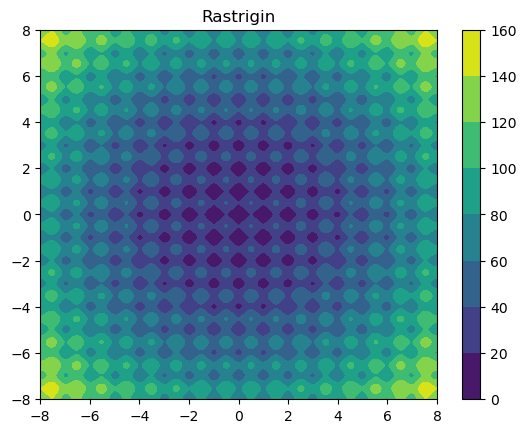

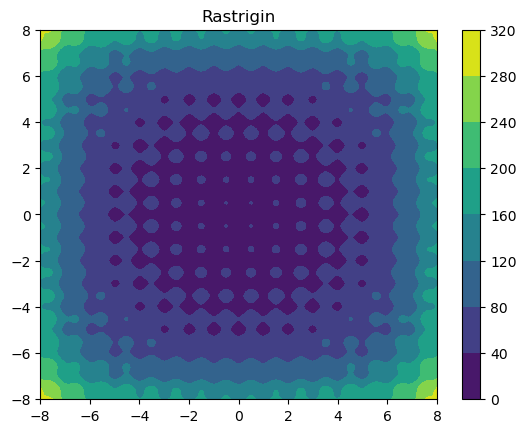

In [186]:
rastringin = Rastrigin(2)

points = np.linspace(-8, 8, 1000)

values = [rastringin([x, y]) for x, y in product(points, points)]

plt.figure()
plt.contourf(points, points, np.array(values).reshape(1000, 1000))
plt.colorbar()
plt.title("Rastrigin")
plt.show()

def rastringin_constrained_generator(rastringin):
    # Método utilizado: Penalização com parâmetro de penalização = 1000
    # Função de penalização 1: p * max(0, (x - 5.12))²
    # Função de penalização 2: p * max(0, (-x - 5.12))²
    # Obs: Por não ser realmente um problema de otimização convexa, iremos deixar o p fixado em 10, o que
    # não é um problema por sabermos que os mínimos locais são maiores que o global.
    p = 10
    def wrapper(x):
        return rastringin(x) + p * sum([max(0, (x_i - 5.12))**2 for x_i in x]) + p * sum([max(0, (-x_i - 5.12))**2 for x_i in x])
    
    return wrapper

rastringin_constrained = rastringin_constrained_generator(rastringin)

values = [rastringin_constrained([x, y]) for x, y in product(points, points)]

plt.figure()
plt.contourf(points, points, np.array(values).reshape(1000, 1000))
plt.colorbar()
plt.title("Rastrigin")
plt.show()

# Função em N=10

A função utilizada no problema real possui 10 dimensões, ou seja, $n=10$.

In [187]:
rastringin = Rastrigin(10)

rastringin_constrained = rastringin_constrained_generator(rastringin)

# Representação

A representação utilizada para cada solução candidata é um vetor de 100 bits, onde os primeiros 10 bits representam a primeira variável, os próximos 10 bits representam a segunda variável, e assim por diante. No fim, teremos um vetor de 100 bits.

Esta representação é utilizada para facilitar a implementação do algoritmo genético, pois permite a utilização de operadores genéticos de maneira mais simples, sendo o escopo do preblema alterado para a seleção de parâmetros eficazes.

> Consideramos que [0, 0, 0, 0, 0, 0, 0, 0, 0, 0] é -5.12 e [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] é 5.12. Assim o gap é 10.24/1024 = 0.01

In [188]:
crossover_rate = 0.8
mutation_rate = 0.01 # Em média uma mutação por indivíduo
max_generations = 1000

def init_population(_mu:int = 100):
    population = []
    for i in range (_mu):
        individual = np.matrix([[rd.choice([0, 1]) for _ in range(10)] for _ in range(10)])
        population.append(individual)
    return population

# Função de Aptidão

A função de aptidão utilizada é a própria função de Rastrigin, que deve ser minimizada.

A implementação aqui presente é capaz de retornar o indivíduo do espaço dos fenótipos para o espaço dos genótipos.

In [189]:
def fitness(individual: np.matrix):
    fenotype = []
    for i in range(individual.shape[0]):
        fenotype.append(-5.12 + 10.24 * int(''.join(map(str, individual[i].tolist()[0])), 2) / 1023)

    return rastringin_constrained(fenotype)

# Mutação da Solução (Bit-Flip)

Realizamos a **mutação** utilizando a técnica de **Bit-Flip**. Para isso, percorremos todos os bits presentes na solução e realizamos a inversão de um bit aleatoriamente com uma probabilidade definida.

> **Exemplo:** Caso tenhamos um bit flip na posição 0 e 1 do vetor [0,1,0,1,0,1,0,1], teremos a mutação [1,0,0,1,0,1,0,1].

In [190]:
def mutate(solution: np.matrix, pm: float):
    for i in range(solution.shape[0]):
        for j in range(solution.shape[1]):
            if rd.random() < pm:
                solution[i, j] = 1 - solution[i, j]
    return solution

# Seleção

São gerados 10 filhos por iteração, de forma que o gap geracional se configure como 1/10. Dentre os filhos escolhidos, cada um deles é substituido pelo pai com uma probabilidade pc.

Dois métodos de seleção foram implementados: **seleção por torneio** e **seleção por roleta**.

Na **seleção por torneio**, selecionamos aleatoriamente 30 indivíduos da população e escolhemos os dois melhores para serem pais.

Na **seleção por roleta**, calculamos a probabilidade de seleção de cada indivíduo (baseado no fitnees) e selecionamos dois pais de acordo com esta probabilidade.

# Crossover

O **crossover** é realizado utilizando a técnica de **crossover de um ponto**. Para isso, selecionamos um ponto aleatório e trocamos os bits a partir deste ponto entre os pais. Não é levado em consideração cada variável individualmente, sendo todas as variáveis "unidas" em um único vetor. Apesar de não ser a melhor abordagem para o problema, é uma abordagem simples e eficaz considerando as dimensionaidades do problema.

In [191]:
def recombine(population: list[np.matrix], pc: float, selection='R') -> list[np.matrix]:

    # Iremos utilizar um modelo com gap geracional 1/10, ou seja, criaremos 10 filhos por geração
    children = []
    for _ in range(10):
        # Selecionando os pais

        if selection == 'R':
            fitting_values = [1/fitness(individual) for individual in population]
            fitting_values_total = sum(fitting_values)
            fitness_cumulative = Series(fitting_values).cumsum()

            # escolhendo um número aleatório na roleta
            random_number = rd.random() * fitting_values_total

            # escolhendo o primeiro pai, é o index com o primeiro número maior que o número aleatório escolhido
            parent_1 = population[fitness_cumulative[fitness_cumulative >= random_number].index[0]]
            parent_1_flat = parent_1.flatten()

            # O mesmo para o segundo pai
            random_number = rd.random() * fitting_values_total
            parent_2 = population[fitness_cumulative[fitness_cumulative >= random_number].index[0]]
            parent_2_flat = parent_2.flatten()

        elif selection == 'T':
            random_possible_parents = [population[i] for i in rd.sample(range(0,len(population)), 30)]

            # Melhores duas possíveis soluções para pais
            best_possible_parents_indexes = np.argpartition([fitness(individual) for individual in random_possible_parents] ,2)[:2]
            parent_1 = random_possible_parents[best_possible_parents_indexes[0]]
            parent_1_flat = parent_1.flatten()
            parent_2 = random_possible_parents[best_possible_parents_indexes[1]]
            parent_2_flat = parent_2.flatten()
        
        if rd.random() > pc:
            children.append(parent_1)
            children.append(parent_2)
            continue

        # excolhendo o ponto de corte, a recombinação será por 1 ponto de corte avaliando todas as variáveis em conjunto
        cut_point = rd.randint(0, 100)
        child_1 = np.concatenate((parent_1_flat[:cut_point], parent_2_flat[cut_point:]), axis=0).reshape(10, 10)
        child_2 = np.concatenate((parent_2_flat[:cut_point], parent_1_flat[cut_point:]), axis=0).reshape(10, 10)
        
        children.append(child_1)
        children.append(child_2)
    
    return children

# Nova população

Os candidatos são mantidos de acordo com o fitness de cada um deles, sendo o tamanho da população constante.

In [192]:
def select_new_population(pop, children):
    # Retirando piores soluções, população constante em 100
    
    for child in children:
        pop.append(child)
    
    elements_indexes_to_pop = np.argpartition([fitness(sol) for sol in pop], -len(children))[-len(children):]
    
    for index in sorted(elements_indexes_to_pop, reverse=True):
        del pop[index]
    
    return pop

# Função de Teste

In [193]:
def find_best_solution(_mu, mutation_rate, selection='R', max_gens = max_generations):
    pop = init_population(_mu)

    current_generation = 0
    fitness_pop_vectors = []

    while True:
        fitness_pop = [fitness(sol) for sol in pop]
        fitness_pop_vectors.append(min(fitness_pop))

        if 0 in fitness_pop or current_generation >= max_gens:
            break

        children = recombine(pop, crossover_rate, selection)

        for i, child in enumerate(children):
            child = mutate(child, mutation_rate)
            children[i] = child

        pop = select_new_population(pop, children)

        current_generation += 1

    best_solution = pop[np.argmin(fitness_pop)]
    
    best_solution_fitness = min(fitness_pop)
    
    return best_solution, best_solution_fitness, current_generation, fitness_pop_vectors

# Método de Seleção

Inicialmente, é realizado um teste quanto ao método de seleção a ser utilizado. Para isso, será utilizado o método de seleção por torneio e por roleta, sendo comparados os resultados obtidos.

O método da roleta é mais eficiente, pois a seleção por torneio não foi capaz de selecionar os melhores indivíduos e apresentar um comportamento de decaimento constante, o que pode prejudicou a convergência do algoritmo.

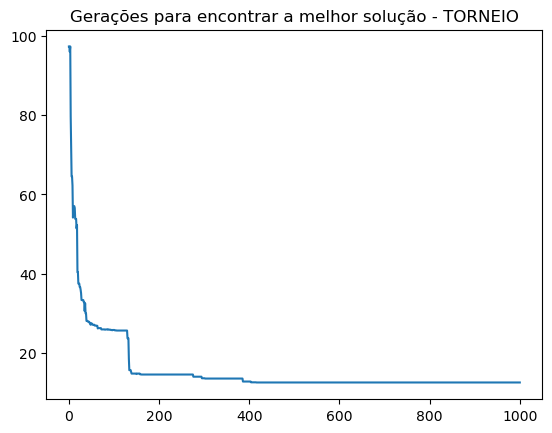

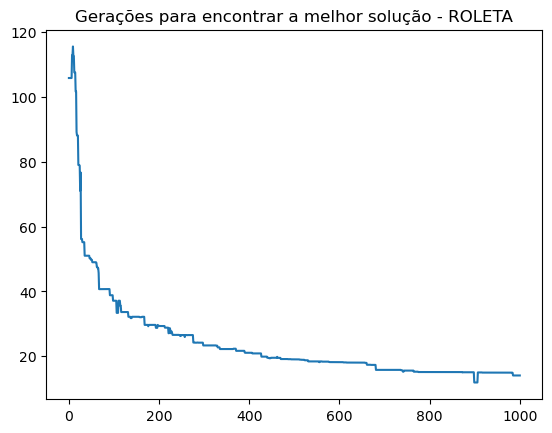

In [194]:
_, _, current_generation, fitness_pop_vectors = find_best_solution(100, mutation_rate=0.01, selection='T')

plt.figure()
plt.plot(fitness_pop_vectors)
plt.title("Gerações para encontrar a melhor solução - TORNEIO")
plt.show()

_, _, current_generation, fitness_pop_vectors = find_best_solution(100, mutation_rate=0.01, selection='R')

plt.figure()
plt.plot(fitness_pop_vectors)
plt.title("Gerações para encontrar a melhor solução - ROLETA")
plt.show()

# Parâmetros de Mutação

Foi realizado um teste para avaliar a influência da probabilidade de mutação no algoritmo. Para isso, foram testados os valores de 0.001, 0.01, 0.1.

O melhor resultado foi obtido com a probabilidade de mutação de 0.01, pois a probabilidade de mutação muito baixa não foi capaz de explorar o espaço de busca, enquanto a probabilidade de mutação muito alta prejudicou a convergência do algoritmo.

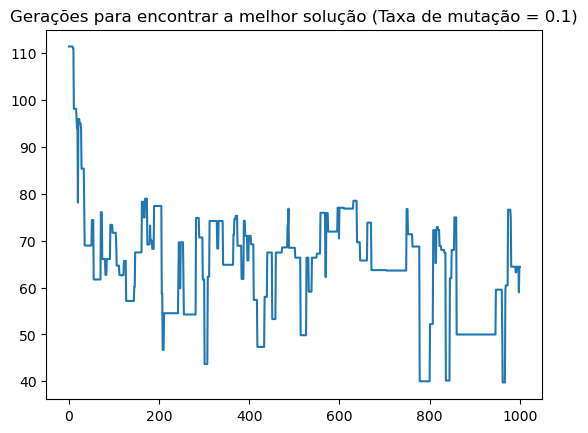

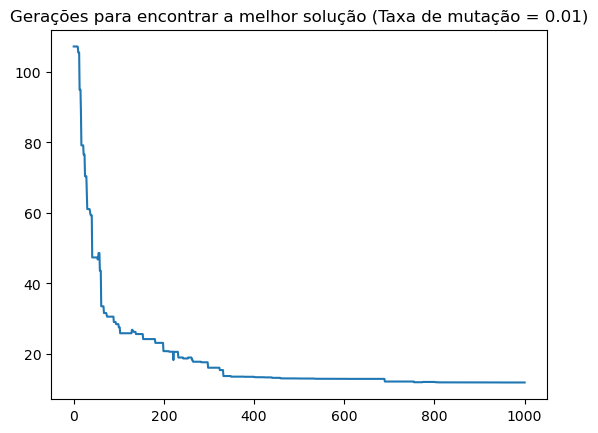

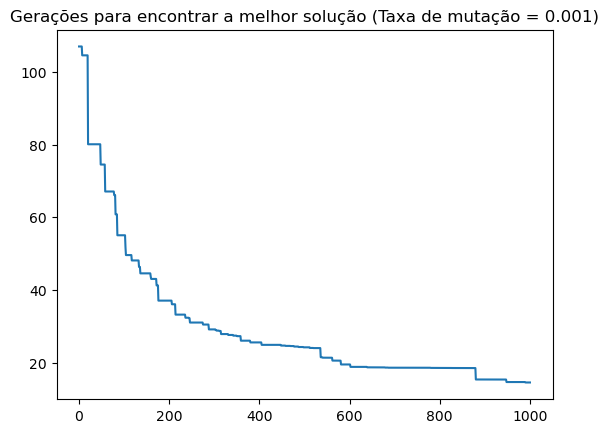

In [195]:
_, _, current_generation, fitness_pop_vectors = find_best_solution(100, mutation_rate=0.1)

plt.figure()
plt.plot(fitness_pop_vectors)
plt.title("Gerações para encontrar a melhor solução (Taxa de mutação = 0.1)")
plt.show()

_, _, current_generation, fitness_pop_vectors = find_best_solution(100, mutation_rate=0.01)

plt.figure()
plt.plot(fitness_pop_vectors)
plt.title("Gerações para encontrar a melhor solução (Taxa de mutação = 0.01)")
plt.show()

_, _, current_generation, fitness_pop_vectors = find_best_solution(100, mutation_rate=0.001)

plt.figure()
plt.plot(fitness_pop_vectors)
plt.title("Gerações para encontrar a melhor solução (Taxa de mutação = 0.001)")
plt.show()

# Parâmetros de Tamanho da População

Foi realizado um teste para avaliar a influência do tamanho da população no algoritmo. Para isso, foram testados os valores de 10, 100 e 1000.

O melhor resultado foi obtido com o tamanho da população de 100, pois o tamanho da população muito baixo não foi capaz de explorar o espaço de busca tão bem quanto o de 100, enquanto o tamanho da população muito alto prejudicou a convergência do algoritmo.

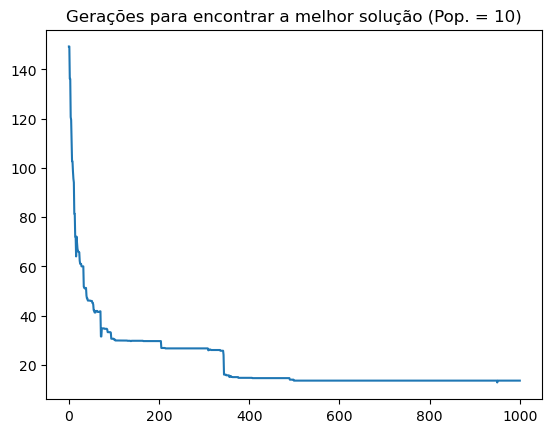

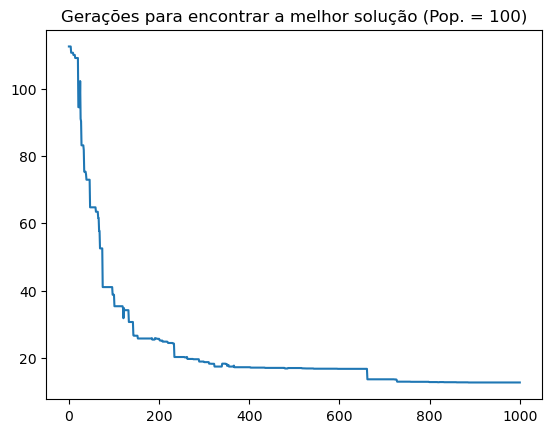

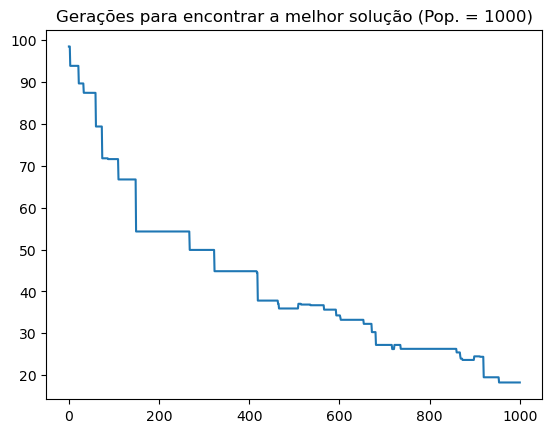

In [197]:
_, _, current_generation, fitness_pop_vectors = find_best_solution(10, mutation_rate=0.01)

plt.figure()
plt.plot(fitness_pop_vectors)
plt.title("Gerações para encontrar a melhor solução (Pop. = 10)")
plt.show()

_, _, current_generation, fitness_pop_vectors = find_best_solution(100, mutation_rate=0.01)

plt.figure()
plt.plot(fitness_pop_vectors)
plt.title("Gerações para encontrar a melhor solução (Pop. = 100)")
plt.show()

_, _, current_generation, fitness_pop_vectors = find_best_solution(1000, mutation_rate=0.01)

plt.figure()
plt.plot(fitness_pop_vectors)
plt.title("Gerações para encontrar a melhor solução (Pop. = 1000)")
plt.show()

# Teste Final

Um teste final foi realizado com os melhores parâmetros encontrados, utilizando um número maior de gerações para avaliar a convergência do algoritmo.

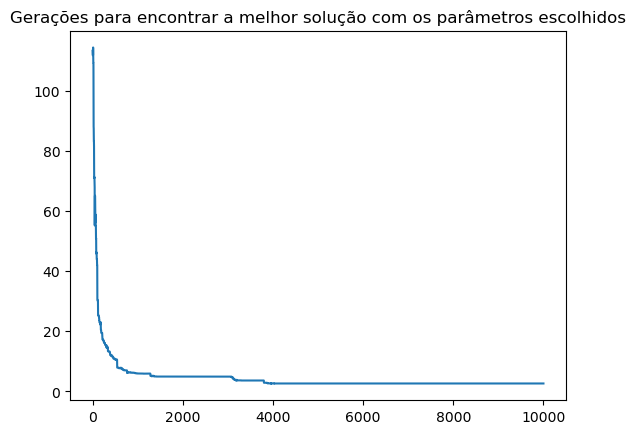

A melhor solução encontrada foi:  2.629098809001718


In [198]:
_, best_solution_fitness, current_generation, fitness_pop_vectors = find_best_solution(100, mutation_rate=0.01, selection='R', max_gens=10000)

plt.figure()
plt.plot(fitness_pop_vectors)
plt.title("Gerações para encontrar a melhor solução com os parâmetros escolhidos")
plt.show()

print("A melhor solução encontrada foi: ", best_solution_fitness)